In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

In [4]:
import theano
import theano.tensor as tt
from lasagne.layers import InputLayer, DenseLayer,rrelu
from lasagne.nonlinearities import sigmoid
import lasagne.layers as layers
import lasagne

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 5005)


In [3]:
N = 9000 # tot datasize
d = 90 # experiment size
p = 0.5 # para for Bernoulli
n1 = 10000 # training sample size
n2 = 10000 # test sample size

In [58]:
def Loss(Y,P):
    # Y should have shape (n,N) and P (N,d)
    return (np.dot(Y,np.log(P)) + np.dot(1-Y,np.log(1-P)))/P.shape[0]

In [4]:
Y_train  = np.random.rand(n1,N)>p
Y_test  = np.random.rand(n2,N)>p

In [5]:
Y_train.shape

(10000, 9000)

In [7]:
P_uniform = np.random.rand(N,d)

In [4]:
P_beta = np.maximum(np.minimum(beta.rvs(0.5,0.5,size=(N,d)),1-1e-4),1e-4)

In [152]:
# add one to make them zero means
C_train = Loss(Y_train,P_uniform).astype(np.float32) + 1
C_test = Loss(Y_test,P_uniform).astype(np.float32) + 1

In [8]:
C_train.shape

(10000, 90)

### Train ANN

In [297]:
batchSize = 50

In [298]:
layer = InputLayer((batchSize, d))
layer = DenseLayer(layer, num_units=d*10, nonlinearity=lasagne.nonlinearities.very_leaky_rectify)
#layer = rrelu(layer)
layer = DenseLayer(layer, num_units=N, nonlinearity=sigmoid)

In [299]:
X_tt = tt.matrix()
y_tt = tt.matrix()
learning_rate_tt = tt.scalar()
m_tt = tt.scalar()

In [300]:
yhat_tt = layers.get_output(layer, X_tt)

In [301]:
cost = -tt.mean(y_tt*tt.log(yhat_tt) + (1-y_tt)*tt.log(1-yhat_tt))

In [302]:
params = lasagne.layers.get_all_params(layer, trainable=True)
#updates = lasagne.updates.nesterov_momentum(
#            cost, params, learning_rate=learning_rate_tt, momentum=m_tt)
updates = lasagne.updates.adam(cost, params, learning_rate=learning_rate_tt)

In [303]:
train_fn = theano.function([X_tt, y_tt,learning_rate_tt], cost, updates=updates)

In [304]:
predict  = theano.function([X_tt],yhat_tt)

In [305]:
loss = theano.function([X_tt, y_tt], cost)

In [306]:
epoch = 10


for i in range(epoch):
    for j in range(n1/batchSize):
        train_fn(C_train[j * batchSize: (j + 1) * batchSize], \
                                           Y_train[j * batchSize: (j + 1) * batchSize],\
                                          1e-2)
    err_train = 0
    for j in range(n1/batchSize):
        err_train += loss(C_train[j * batchSize: (j + 1) * batchSize], \
                                           Y_train[j * batchSize: (j + 1) * batchSize])        

    err_test = 0
    for j in range(n2/batchSize):
        err_test += loss(C_test[j * batchSize: (j + 1) * batchSize], \
                                           Y_test[j * batchSize: (j + 1) * batchSize])  
    print 'epoch:{}, err_train:{}, err_test:{}'.format(i,err_train/n1*batchSize,err_test/n2*batchSize)

epoch:0, err_train:0.689614560604, err_test:0.692104171216
epoch:1, err_train:0.68720859915, err_test:0.694021153748
epoch:2, err_train:0.68579628408, err_test:0.69416043669
epoch:3, err_train:0.685187106729, err_test:0.694268585443
epoch:4, err_train:0.684875157475, err_test:0.694533845186
epoch:5, err_train:0.684741849005, err_test:0.694966739714
epoch:6, err_train:0.684510119557, err_test:0.694979871213
epoch:7, err_train:0.684315468073, err_test:0.695166952312
epoch:8, err_train:0.684133143425, err_test:0.695542790592
epoch:9, err_train:0.684044878781, err_test:0.695857040286


In [75]:
np.log(0.5)

-0.69314718055994529

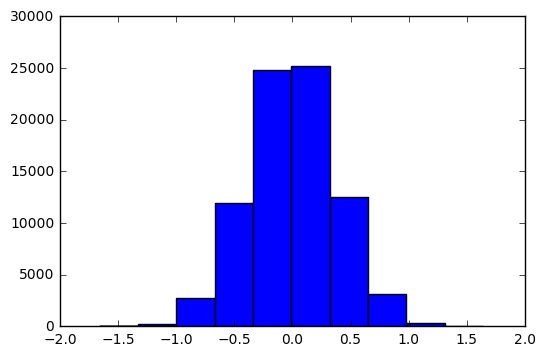

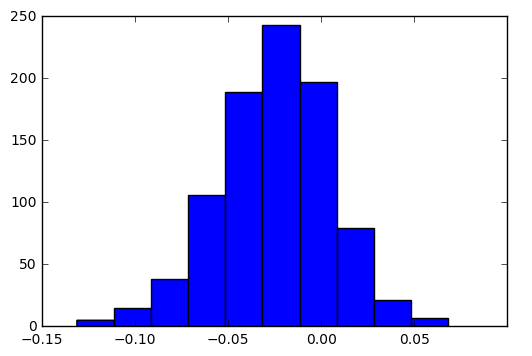

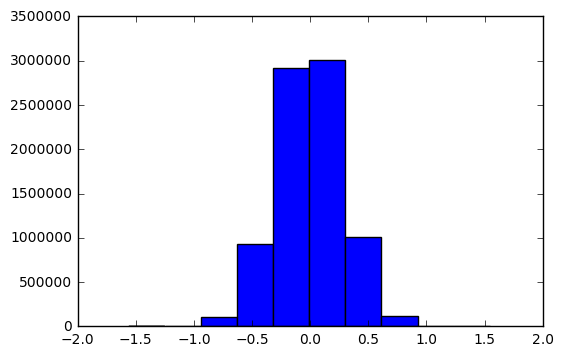

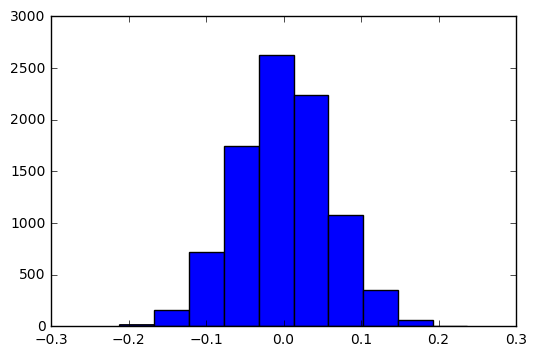

In [307]:
for p in params:
    plt.hist(p.get_value().flatten())
    plt.show()

In [190]:
a = params[0]

In [46]:
y0=predict(C_train[:batchSize])

(array([   10.,    80.,   527.,  1662.,  2939.,  2760.,  1482.,   451.,
           80.,     9.]),
 array([-0.03128362, -0.02382081, -0.01635801, -0.0088952 , -0.00143239,
         0.00603041,  0.01349322,  0.02095602,  0.02841883,  0.03588163,
         0.04334444]),
 <a list of 10 Patch objects>)

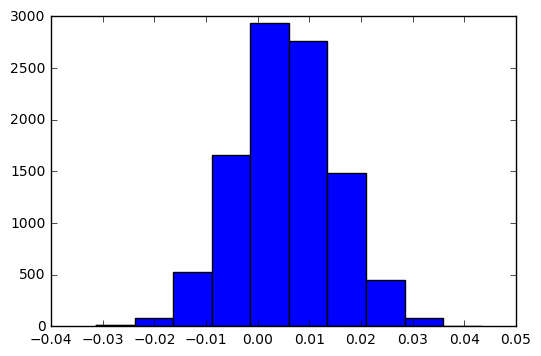

In [153]:
plt.hist(C_train[:,0])

(array([   14.,   119.,   561.,  1636.,  2784.,  2789.,  1500.,   507.,
           81.,     9.]),
 array([-0.03434277, -0.0270713 , -0.01979983, -0.01252836, -0.00525689,
         0.00201458,  0.00928605,  0.01655751,  0.02382898,  0.03110045,
         0.03837192]),
 <a list of 10 Patch objects>)

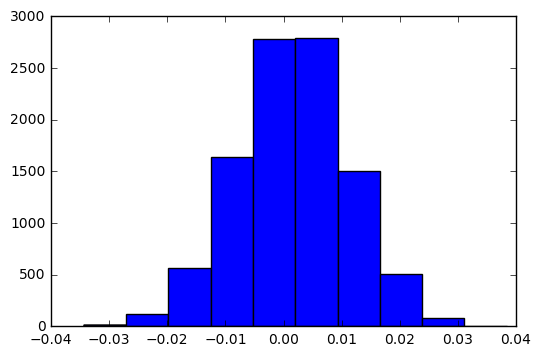

In [154]:
plt.hist(C_train[:,1])

In [155]:
np.std(C_train,0)

array([ 0.00948766,  0.0095285 ,  0.00951564,  0.0096427 ,  0.00969364,
        0.00949789,  0.00963455,  0.00961733,  0.00959555,  0.009373  ,
        0.00942262,  0.00950524,  0.00955212,  0.00938192,  0.00952866,
        0.00957543,  0.00965639,  0.0095996 ,  0.00957522,  0.00958839,
        0.00963741,  0.00953943,  0.00957789,  0.00946953,  0.00963408,
        0.00949722,  0.00946613,  0.00959153,  0.00949094,  0.0095606 ,
        0.00959773,  0.00941864,  0.00950977,  0.00950973,  0.00984407,
        0.0095374 ,  0.00941113,  0.00961193,  0.00932337,  0.00955051,
        0.00969428,  0.00938797,  0.00985779,  0.00975842,  0.00951831,
        0.0094774 ,  0.00957638,  0.00987185,  0.00965145,  0.00957723,
        0.00959852,  0.00957338,  0.00960829,  0.00975172,  0.00970769,
        0.00966112,  0.00956394,  0.00971999,  0.00950419,  0.00975455,
        0.00951419,  0.00965179,  0.00953375,  0.00949359,  0.00971331,
        0.00955145,  0.00966069,  0.00939425,  0.00969758,  0.00

In [156]:
np.mean(C_train,0)

array([ 0.00560709,  0.00162891,  0.00098629, -0.00539697, -0.00414292,
       -0.0020789 ,  0.00014745, -0.00164009,  0.00079338,  0.00549056,
        0.00078585, -0.00188549, -0.00418125,  0.00974758, -0.00072617,
        0.00107343, -0.00598398, -0.00114792,  0.00141972, -0.00397507,
       -0.00517931,  0.00142427,  0.00168768, -0.00167463, -0.00638193,
        0.00327363, -0.00389003,  0.00031471,  0.00268533,  0.00138777,
        0.00331931,  0.00184842,  0.0016959 ,  0.00145644, -0.00816135,
        0.00101269,  0.00337672, -0.00074703,  0.00722189, -0.00041227,
       -0.00064137,  0.00263173, -0.01241963, -0.00472104,  0.00201806,
        0.00217457,  0.00337308, -0.00654791,  0.00024274,  0.00437307,
       -0.00131643,  0.00355926,  0.00085678, -0.00198839, -0.00381185,
       -0.00501515,  0.00469383, -0.00275032,  0.00274809, -0.00915059,
        0.00134336, -0.0013232 ,  0.00235903, -0.00198504, -0.00390541,
        0.00139827, -0.00564536,  0.00491303, -0.00350712,  0.00

In [41]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import ExtraTreeRegressor

In [20]:
def LossMask(Y,P,mask):
    # Y should have shape (n,N), P (N,d) and mask (n,N)
    return (np.dot(Y*mask,np.log(P)) + np.dot((1-Y)*mask,np.log(1-P)))/np.sum(mask,1,keepdims=True)

def dataGenMask(n,N,p1,p2,P):
    # P should be of shape (N,d) and serves as hyper-para
    # p1 is the prob for Y, p2 for mask
    #mask = np.broadcast_to(np.random.rand(1,N)>p2,(n,N))
    while True:
        Y = np.random.rand(n,N)>p1
        mask = np.random.rand(n,N)>p2
        C = LossMask(Y,P,mask)
        yield (C,mask)

def LossY(Y,P):
    # Y should have shape (n,N) and P (N,d)
    return (np.dot(Y,np.log(P)) + np.dot(1-Y,np.log(1-P)))/P.shape[0]

def dataGenY(n,N,p,P):
    # P should be of shape (N,d)
    while True:
        Y = np.random.rand(n,N)>p
        C = LossY(Y,P)
        yield (C,Y)

logLoss = lambda y,p: np.mean(y*np.log(p) + (1-y)*np.log(1-p))

def sigmoid(x):
    return 1/(1+np.exp(-x))
    
class GBM_k_BinaryOutput(BaseEstimator, ClassifierMixin):
    
    def __init__(self,BaseEst,M_est,learnRate,BasePara,K,baseline):
        self.BaseEst=BaseEst
        self.M_est=M_est
        self.learnRate=learnRate
        self.estimator_=[]
        self.BasePara=BasePara
        self.K = K
        self.baseline = baseline
        
    def fit(self,dataGen,restart=True,M_add=None):
          
        if M_add==None:
            M_add=self.M_est
            
        if restart==True:
            self.estimator_=[]

        for m in range(M_add):
            X,Y = dataGen.next()
            yp = self.predict_proba(X)
            print "iteration:{}, logLoss:{}".format(m,logLoss(Y,yp))
            self.estimator_.append(self.BaseEst(**self.BasePara).fit(X,Y-yp))

        self.M_est=len(self.estimator_)
        return self
        
        
    def predict_raw(self,X):
        yhat=np.copy(self.baseline)
        for m in self.estimator_:
            yhat=yhat+m.predict(X)
        return yhat       
        
    def predict_class(self,X):
        return self.predict_raw(X)>0

    def predict_proba(self,X):
        return sigmoid(self.learnRate*self.predict_raw(X))
         
    def plot_MLE(self,X,y):
        accr=np.zeros(self.M_est)        
        y_raw=np.copy(self.baseline)
            
        for m in range(self.M_est):
            y_raw=y_raw + self.learnRate*self.estimator_[m].predict(X)
            yp=sigmoid(y_raw)
            accr[m]=logLoss(y,yp)
        plt.plot(accr)



In [30]:
P_beta = np.maximum(np.minimum(beta.rvs(0.5,0.5,size=(N,N/2)),1-1e-4),1e-4)

In [32]:
Model=GBM_k_BinaryOutput(ExtraTreeRegressor,20,0.01,\
                         {'max_depth':8,'splitter':'random','max_features':0.5},\
                        N,np.zeros(N))

Model.fit(dataGenMask(1000,N,0.5,0.5,P_beta))

iteration:0, logLoss:-0.69314718056
iteration:1, logLoss:-0.693147798283
iteration:2, logLoss:-0.693148975434


KeyboardInterrupt: 

In [17]:
X,Mask = dataGenMask(1000,N,0.5,0.5,P_beta).next()

In [18]:
yp=Model.predict_proba(X)

In [19]:
logLoss(Mask,yp)

-0.69942542693242538

In [66]:
def LossMask(Y,P,mask):
    # Y should have shape (n,N), P (N,d) and mask (n,N)
    return (np.dot(Y*mask,np.log(P)) + np.dot((1-Y)*mask,np.log(1-P)))/np.sum(mask,1,keepdims=True)

def dataGenMaskY(n,N,p1,p2,P):
    # P should be of shape (N,d) and serves as hyper-para
    # p1 is the prob for Y, p2 for mask
    while True:
        Y = np.random.rand(n,N)>p1
        mask = np.random.rand(n,N)>p2
        C = LossMask(Y,P,mask)
        ret = np.zeros((n,N,2),dtype=np.int32) # 3 classes, K-1 =2
        ret[:,:,0] = 1-Y
        ret[:,:,1] = Y
        ret = ret * mask[:,:,np.newaxis]
        yield (C,np.reshape(ret,(n,N*2)))


In [67]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def logLoss(y,yp):
    return np.mean(y*np.log(yp))
    
class GBM_KD(BaseEstimator, ClassifierMixin):
    # predict D output, each having K classes. So the total number of output
    # will be K*D. training data is provided in the form of a generator.
    
    def __init__(self,BaseEst,M_est,learnRate,BasePara,K,D,baseline):
        self.BaseEst=BaseEst
        self.M_est=M_est
        self.learnRate=learnRate
        self.estimator_=[]
        self.BasePara=BasePara
        self.K = K
        self.D = D
        self.baseline = baseline # should be of the shape (K*D,)
        
    def fit(self,dataGen,restart=True,M_add=None):
          
        if M_add==None:
            M_add=self.M_est
            
        if restart==True:
            self.estimator_=[]

        for m in range(M_add):
            X,Y = dataGen.next()
            yp = self.predict_proba(X)
            print "iteration:{}, logLoss:{}".format(m,logLoss(Y,yp)) # partial loss. Does not have class mask.
            self.estimator_.append(self.BaseEst(**self.BasePara).fit(X,Y-yp))

            
        self.M_est=len(self.estimator_)
        return self
        
        
    def predict_raw(self,X):
        yhat=np.copy(self.baseline)
        for m in self.estimator_:
            yhat=yhat+m.predict(X)
        return yhat       
        
    def predict_class(self,X):
        return self.predict_raw(X)>0

    def predict_proba(self,X):
        temp = np.exp(np.reshape(self.learnRate*self.predict_raw(X),(-1,self.D,self.K-1)))
        return np.reshape(temp/(np.sum(temp,2,keepdims=True)+1),(-1,self.D*(self.K-1)))
         
    def plot_MLE(self,X,y):
        accr=np.zeros(self.M_est)        
        y_raw=np.copy(self.baseline)
            
        for m in range(self.M_est):
            y_raw=y_raw + self.learnRate*self.estimator_[m].predict(X)
            yp=sigmoid(y_raw)
            accr[m]=logLoss(y,yp)
        plt.plot(accr)

In [78]:
p_ = np.array([0.25,0.25,0.5])

In [79]:
r = 0.0001

In [80]:
baseline = np.repeat(np.log(p_[:2]/p_[2]) / r, N)

In [81]:
baseline.shape

(18000,)

In [82]:
Model=GBM_KD(ExtraTreeRegressor,20,0.0001,\
                         {'max_depth':12,'splitter':'random','max_features':0.8},\
                        3,N,baseline)
Model.fit(dataGenMaskY(3000,N,0.5,0.5,P_beta))

iteration:0, logLoss:-0.346660130989
iteration:1, logLoss:-0.346716730723
iteration:2, logLoss:-0.346517455725
iteration:3, logLoss:-0.346485126588
iteration:4, logLoss:-0.346507143699
iteration:5, logLoss:-0.346540092924
iteration:6, logLoss:-0.346751196354
iteration:7, logLoss:-0.34656682399
iteration:8, logLoss:-0.346566713172
iteration:9, logLoss:-0.346520006511
iteration:10, logLoss:-0.346620794973
iteration:11, logLoss:-0.346488909551
iteration:12, logLoss:-0.346607077776
iteration:13, logLoss:-0.346606580468
iteration:14, logLoss:-0.346564939045
iteration:15, logLoss:-0.346630512707
iteration:16, logLoss:-0.346555658508
iteration:17, logLoss:-0.346533048901
iteration:18, logLoss:-0.346728015463
iteration:19, logLoss:-0.346518081116


GBM_KD(BaseEst=<class 'sklearn.tree.tree.ExtraTreeRegressor'>,
    BasePara={'max_features': 0.8, 'splitter': 'random', 'max_depth': 12},
    D=9000, K=3, M_est=20,
    baseline=array([-6931.47181, -6931.47181, ..., -6931.47181, -6931.47181]),
    learnRate=0.0001)